In [1]:
import matplotlib.pyplot as plt
from datetime import date, timedelta
from lithops import Storage, storage
from lithops.multiprocessing import Pool
import json
import pandas as pd 


def getCountAverageSentiment(data):

    datasCounts = [dataCount['SetimentCount'] for dataCount in data]
    totalNumPostsSentiment = sum([dataCount['NumPostSent'] for dataCount in data])
    datasCountsAvg = {}
    
    for dataCount in datasCounts:
        for key in dataCount:
            if key in datasCountsAvg:
                datasCountsAvg[key] += dataCount[key] 
            else:
                datasCountsAvg[key] = dataCount[key] 
    
    return [datasCountsAvg[key] / totalNumPostsSentiment * 1000 for key in datasCountsAvg]


def getDays(dateIni, dateFin):

    days = []
    
    if dateIni > dateFin:
        dateIni, dateFin = dateFin, dateIni

    if dateFin > date.today():
        dateFin = date.today()
    
    cont = 1
    while dateIni != dateFin:
        days.append(dateIni)
        dateIni += timedelta(days=1)
        
    days.append(dateIni)
    return days


def getDataReddit(date):

    dataPosts = {
        "NumPosts": 0,
        "NumPostSent": 0,
        "NumPostNoSent": 0,
        "NumPostsPositive": 0,
        "NumPostsNegative": 0,
        "SentimentAvg": 0,
        "SetimentCount": {}
    }

    # Initialize sentiment count
    for i in range(-10,11):
        if i == 0:
            dataPosts["SetimentCount"]["-"+str(i)] = 0
        dataPosts["SetimentCount"][str(i)] = 0

    storageCloud = Storage()
    try:
        data = json.loads(storageCloud.get_object('test-bythepego', 'reddit/'+date+'.json'))
    except storage.utils.StorageNoSuchKeyError:
        return dataPosts

    for post in data['posts']:
        if post['sentiment'] != 0: # with sentiment
            dataPosts['SentimentAvg'] += post['sentiment']
            dataPosts['NumPostSent'] += 1

            if post['sentiment'] > 0: # sentiment positive
                dataPosts['NumPostsPositive'] += 1
            else: # sentiment negative
                dataPosts['NumPostsNegative'] += 1

            if post['sentiment'] > 0 or post['sentiment'] <= -0.1:
                dataPosts['SetimentCount'][str(int(post['sentiment']*10))] += 1
            elif post['sentiment'] < 0:
                dataPosts['SetimentCount']["-"+str(int(post['sentiment']*10))] += 1

        else:  # without sentiment
            dataPosts['NumPostNoSent'] += 1
        dataPosts['NumPosts'] += 1

    if dataPosts['NumPostSent'] != 0:
        dataPosts['SentimentAvg'] /= dataPosts['NumPostSent']


    return dataPosts

def getDataTwitter(date):

    dataPosts = {
        "NumPosts": 0,
        "NumPostSent": 0,
        "NumPostNoSent": 0,
        "NumPostsPositive": 0,
        "NumPostsNegative": 0,
        "SentimentAvg": 0,
        "SetimentCount": {}
    }

    # Initialize sentiment count

    for i in range(-10,11):
        if i == 0:
            dataPosts["SetimentCount"]["-"+str(i)] = 0

        dataPosts["SetimentCount"][str(i)] = 0
        

    storageCloud = Storage()
    try:
        data = json.loads(storageCloud.get_object('test-bythepego', 'twitter/'+date+'.json'))
    except storage.utils.StorageNoSuchKeyError:
        return dataPosts

    for post in data['tweets']:
        if post['sentiment'] != 0: # with sentiment
            dataPosts['SentimentAvg'] += post['sentiment']
            dataPosts['NumPostSent'] += 1

            if post['sentiment'] > 0: # sentiment positive
                dataPosts['NumPostsPositive'] += 1
            else: # sentiment negative
                dataPosts['NumPostsNegative'] += 1

            if post['sentiment'] > 0 or post['sentiment'] <= -0.1:
                dataPosts['SetimentCount'][str(int(post['sentiment']*10))] += 1
            elif post['sentiment'] < 0:
                dataPosts['SetimentCount']["-"+str(int(post['sentiment']*10))] += 1

 
        else:  # without sentiment
            dataPosts['NumPostNoSent'] += 1
        dataPosts['NumPosts'] += 1

    if dataPosts['NumPostSent'] != 0:
        dataPosts['SentimentAvg'] /= dataPosts['NumPostSent']

    return dataPosts

def getDataBitcoin(date): 
    storageCloud = Storage()
    try:
        data = json.loads(storageCloud.get_object('test-bythepego', 'bitcoin/'+date+'.json'))
    except storage.utils.StorageNoSuchKeyError:
        return 0
    
    priceAvg = 0
    for price in data['priceArray']:
        priceAvg += price
    
    if priceAvg != 0:
        priceAvg /= len(data['priceArray'])

    return priceAvg




def getData(dateIni, dateFin):
    days = getDays(dateIni,dateFin)
    strDays = [str(day) for day in days]

    with Pool() as pool:
        resultRedditAsync = pool.map_async(getDataReddit, strDays)
        resultTwitterAsync = pool.map_async(getDataTwitter, strDays)
        resultBitcoinAsync = pool.map_async(getDataBitcoin, strDays)
        
    return resultRedditAsync.get(), resultTwitterAsync.get(), resultBitcoinAsync.get(), days




In [2]:
# Call lithops function
dataReddit, dataTwitter, dataBitcoin, days = getData(date.today()-timedelta(days=9), date.today())

2021-06-06 18:23:14,675 [INFO] lithops.config -- Lithops v2.3.3
2021-06-06 18:23:14,870 [INFO] lithops.storage.backends.ibm_cos.ibm_cos -- IBM COS Storage client created - Region: eu-gb
2021-06-06 18:23:14,870 [INFO] lithops.serverless.backends.ibm_cf.ibm_cf -- IBM CF client created - Region: eu-gb - Namespace: joel.panisello@estudiants.urv.cat_dev
2021-06-06 18:23:14,871 [INFO] lithops.executors -- Serverless Executor created with ID: 1c8bb1-0
2021-06-06 18:23:14,871 [INFO] lithops.invokers -- ExecutorID 1c8bb1-0 | JobID M000 - Selected Runtime: lithopscloud/ibmcf-python-v39 - 256MB
2021-06-06 18:23:14,879 [INFO] lithops.job.job -- ExecutorID 1c8bb1-0 | JobID M000 - Uploading function and data - Total: 2.1KiB
2021-06-06 18:23:15,291 [INFO] lithops.invokers -- ExecutorID 1c8bb1-0 | JobID M000 - Starting function invocation: None() - Total: 10 activations
2021-06-06 18:23:15,298 [INFO] lithops.invokers -- ExecutorID 1c8bb1-0 | JobID M000 - View execution logs at /tmp/lithops/logs/1c8bb1

    0%|          | 0/10  

2021-06-06 18:23:34,220 [INFO] lithops.wait -- ExecutorID 1c8bb1-0 - Getting results from functions


    0%|          | 0/10  

2021-06-06 18:23:34,329 [INFO] lithops.executors -- ExecutorID 1c8bb1-0 - Cleaning temporary data
2021-06-06 18:23:34,357 [INFO] lithops.wait -- ExecutorID 1c8bb1-0 - Waiting for functions to complete


    0%|          | 0/10  

2021-06-06 18:23:34,432 [INFO] lithops.wait -- ExecutorID 1c8bb1-0 - Getting results from functions


    0%|          | 0/10  

2021-06-06 18:23:34,638 [INFO] lithops.executors -- ExecutorID 1c8bb1-0 - Cleaning temporary data
2021-06-06 18:23:34,655 [INFO] lithops.wait -- ExecutorID 1c8bb1-0 - Waiting for functions to complete
2021-06-06 18:23:34,659 [INFO] lithops.wait -- ExecutorID 1c8bb1-0 - Getting results from functions


    0%|          | 0/10  

2021-06-06 18:23:34,857 [INFO] lithops.executors -- ExecutorID 1c8bb1-0 - Cleaning temporary data


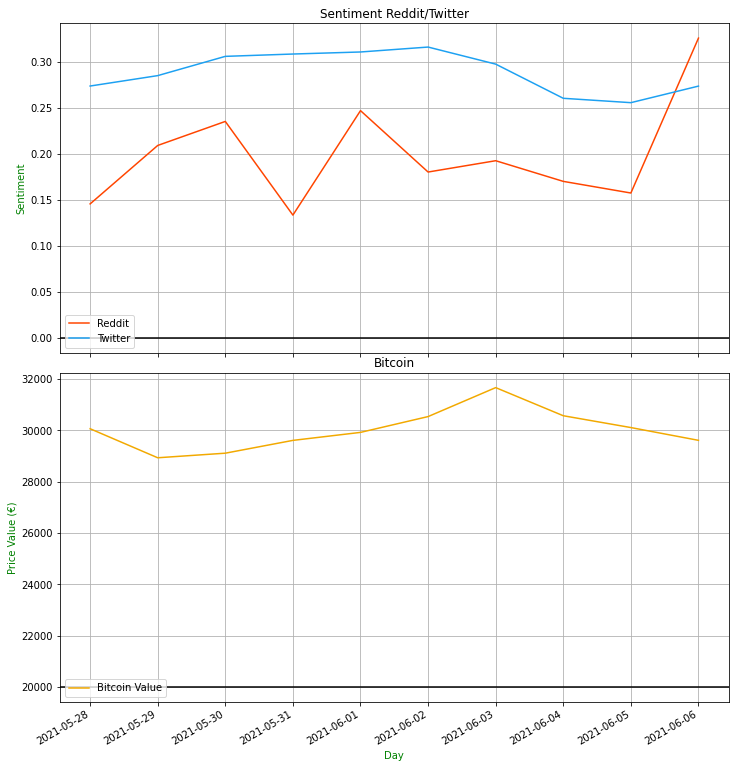

In [3]:
# Linear charts
dataRedditSentiment = [post['SentimentAvg'] for post in dataReddit]
dataTwitterSentiment = [post['SentimentAvg'] for post in dataTwitter]

fig, axs = plt.subplots(2, figsize=(10,10), sharex=True)
fig.tight_layout(pad=1.0)

lineReddit = axs[0].plot(days, dataRedditSentiment, color='#FF4500')
lineTwitter = axs[0].plot(days, dataTwitterSentiment, color='#1da1f2')

axs[0].set_ylabel('Sentiment',color="green")
axs[0].set_title('Sentiment Reddit/Twitter')
axs[0].legend(['Reddit', 'Twitter'], loc=3)
axs[0].axhline(y=0, color='black', linestyle='-')
axs[0].grid(True)

lineReddit = axs[1].plot(days, dataBitcoin, color='#f2a900')
axs[1].set_xlabel('Day',color="green")
axs[1].set_ylabel('Price Value (€)',color="green")
axs[1].set_title('Bitcoin')
axs[1].legend(['Bitcoin Value'], loc=3)
axs[1].axhline(y=20000, color='black', linestyle='-')
axs[1].grid(True)


plt.setp(axs[0].get_xticklabels(), rotation=30, horizontalalignment='right')
plt.setp(axs[1].get_xticklabels(), rotation=30, horizontalalignment='right')

plt.show()

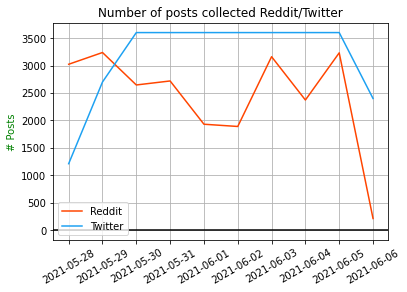

In [4]:
# Number of posts
dataRedditSentiment = [post['NumPosts'] for post in dataReddit]
dataTwitterSentiment = [post['NumPosts'] for post in dataTwitter]


lineReddit = plt.plot(days, dataRedditSentiment, color='#FF4500')
lineTwitter = plt.plot(days, dataTwitterSentiment, color='#1da1f2')

plt.ylabel('# Posts',color="green")
plt.title('Number of posts collected Reddit/Twitter')
plt.legend(['Reddit', 'Twitter'], loc=3)
plt.axhline(y=0, color='black', linestyle='-')
plt.grid(True)
plt.xticks(rotation=30)
plt.show()

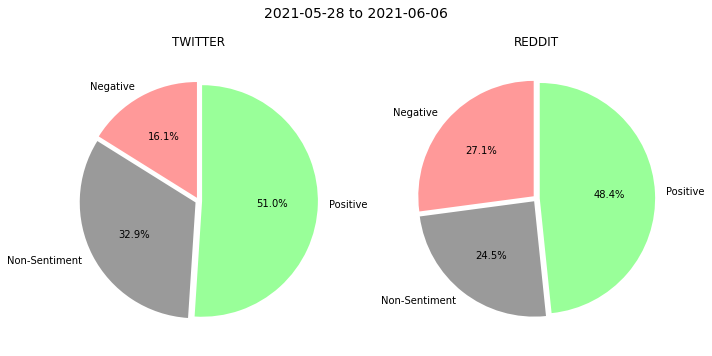

In [5]:
# Get data
totalPositivePostsTwitter = sum([post['NumPostsPositive'] for post in dataTwitter])
totalNegativePostsTwitter = sum([post['NumPostsNegative'] for post in dataTwitter])
totalNoSentPostsTwitter = sum([post['NumPostNoSent'] for post in dataTwitter])

totalPositivePostsReddit = sum([post['NumPostsPositive'] for post in dataReddit])
totalNegativePostsReddit = sum([post['NumPostsNegative'] for post in dataReddit])
totalNoSentPostsReddit = sum([post['NumPostNoSent'] for post in dataReddit])

fig, (ax1,ax2) = plt.subplots(1,2, figsize=(10,5))

# Pie chart
labels = ['Negative', 'Non-Sentiment', 'Positive']
colors = ['#ff9999','#9a9a9a','#99ff99']
explode = (0.03,0.03,0.03)

sizesTwitter = [totalNegativePostsTwitter, totalNoSentPostsTwitter, totalPositivePostsTwitter]

ax1.pie(sizesTwitter, labels=labels, colors=colors, autopct='%1.1f%%', startangle=90, explode = explode)
ax1.axis('equal')
ax1.set_title("TWITTER")

sizesReddit = [totalNegativePostsReddit, totalNoSentPostsReddit, totalPositivePostsReddit]
ax2.pie(sizesReddit, labels=labels, colors=colors, autopct='%1.1f%%', startangle=90, explode = explode)
ax2.axis('equal')
ax2.set_title("REDDIT")
fig.suptitle(str(min(days)) + " to " + str(max(days)), fontsize=14)
plt.tight_layout()
plt.show()

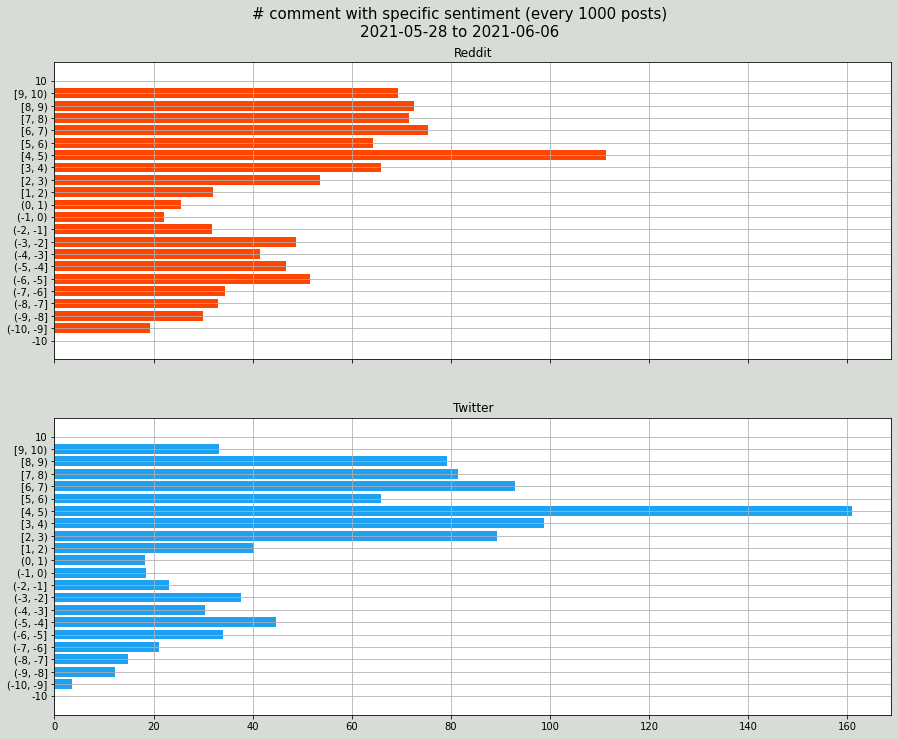

In [6]:
# Population Pyramids
df = pd.DataFrame({'Sent': ['-10', '(-10, -9]','(-9, -8]','(-8, -7]','(-7, -6]','(-6, -5]','(-5, -4]','(-4, -3]','(-3, -2]','(-2, -1]','(-1, 0)','(0, 1)','[1, 2)','[2, 3)','[3, 4)','[4, 5)','[5, 6)', '[6, 7)', '[7, 8)','[8, 9)','[9, 10)','10'], 
                    'Reddit': getCountAverageSentiment(dataReddit), 
                    'Twitter': getCountAverageSentiment(dataTwitter)})


#define x and y limits
y = range(0, len(df))
x_reddit = df['Reddit']
x_twitter = df['Twitter']

#define plot parameters
fig, axes = plt.subplots(ncols=1, nrows=2, sharex=True, sharey=True, figsize=(15, 12))

#specify background color and plot title
fig.patch.set_facecolor('xkcd:light grey')
plt.figtext(.5,.91,"# comment with specific sentiment (every 1000 posts)\n" + str(min(days)) + " to " + str(max(days)), fontsize=15, ha='center')
    
#define bars
axes[0].barh(y, x_reddit, align='center', color='#FF4500')
axes[0].set(title='Reddit')
axes[1].barh(y, x_twitter, align='center', color='#1da1f2')
axes[1].set(title='Twitter')

#adjust grid parameters and specify labels for y-axis
axes[1].grid()
axes[0].set(yticks=y, yticklabels=df['Sent'])
axes[0].grid()

#display plot
plt.show()          